# 라이브러리 임포트 및 함수 정의

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
from matplotlib import font_manager, rc
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

# 클러스터링

처음에는 모든 Feature에 대해서 정규화를 해주고(클러스터링에 도움된다고 하여서) 표준화를 해준 뒤에 클러스터링을 진행해주었습니다.

* 표준화

In [2]:
# 데이터 호출
data = pd.read_csv('C:/Users/hyunj/Desktop/데이터마이닝 코드/New_After_Preprocessing.csv', encoding='CP949')
data_man = data.loc[data['성별코드'] == 1]

data_man = data_man.loc[(data_man['연령대 코드(5세단위)'] == 11) | (data_man['연령대 코드(5세단위)'] == 12)]
data_man.drop('성별코드', axis =1, inplace=True)
data_man.drop('연령대 코드(5세단위)', axis = 1, inplace = True)
data_man.drop('요단백', axis = 1, inplace = True)
data_man.reset_index(inplace = True, drop=True)
columns = list(data_man.columns)

# 표준화 이전의 Original Data 변수 저장
original_data_man2 = data_man.copy()

# 로그 트랜스폼 
for feature in columns :
    data_man[feature] = np.log1p(data_man[feature])
    
# 표준화
from sklearn.preprocessing import StandardScaler 
scaled_data_man = StandardScaler().fit_transform(data_man)
scaled_data_man_df = pd.DataFrame(scaled_data_man, columns=data_man.columns)
data_man = scaled_data_man_df.copy()

# 표준화를 해준 데이터 변수 저장
original_data_man = data_man.copy()

* 최적 k 개수 찾기 (Elbow Graph)

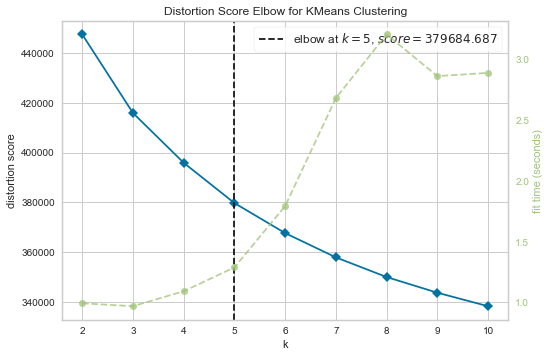

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [3]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Kmeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=10)

visualizer.fit(data_man)        # Fit the data to the visualizer
visualizer.show()

로그 트랜스폼과 표준화를 해준 50대 남자의 데이터는 클러스터의 개수가 5개일 때 최적인 것을 확인

* K-Means 클러스터링 후 실루엣 계수 계산

In [4]:
# K-Means 클러스터링
kmeans = KMeans(n_clusters=5, n_init=15, max_iter=300, random_state=0)
clusters = kmeans.fit_predict(data_man)
centroids = kmeans.cluster_centers_

original_data_man['cluster'] = clusters
original_data_man2['cluster'] = clusters

# 실루엣 계수 계산
score_samples = silhouette_samples(original_data_man[original_data_man.columns], original_data_man['cluster'])
print(score_samples.shape)
print(score_samples)
original_data_man['silhoutte_coeff'] = score_samples

average_score = silhouette_score(original_data_man[original_data_man.columns], original_data_man['cluster'])
print(average_score)
print(original_data_man.groupby('cluster')['silhoutte_coeff'].mean())

(33697,)
[0.15999655 0.14549881 0.21422225 ... 0.0989137  0.13437776 0.08266988]
0.1258278695201902
cluster
0    0.111156
1    0.140685
2    0.109377
3    0.145895
4    0.112693
Name: silhoutte_coeff, dtype: float64


* 2차원 PCA 후 시각화

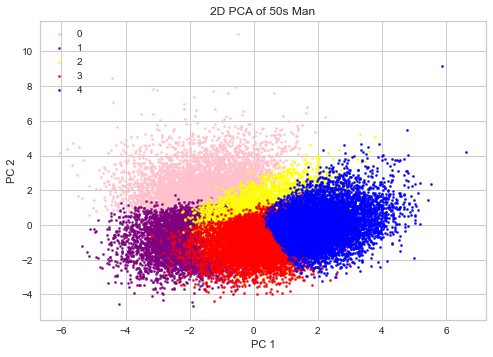

In [5]:
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA


temp_data = original_data_man.drop('cluster', axis = 1)
scaled_data_man = StandardScaler().fit_transform(original_data_man)
scaled_data_man_df = pd.DataFrame(scaled_data_man, columns=original_data_man.columns)


pca2 = PCA(n_components=2)
data_pca2 = pca2.fit_transform(scaled_data_man_df)
pca_df = pd.DataFrame(data_pca2, columns = ['component 0', 'component 1'])
pca_df['target'] = original_data_man['cluster']

# target 별 분리
pca_df_0 = pca_df[pca_df['target'] == 0]
pca_df_1 = pca_df[pca_df['target'] == 1]
pca_df_2 = pca_df[pca_df['target'] == 2]
pca_df_3 = pca_df[pca_df['target'] == 3]
pca_df_4 = pca_df[pca_df['target'] == 4]

# target 별 시각화
plt.scatter(pca_df_0['component 0'], pca_df_0['component 1'], s = 5, color = 'pink', label = '0')
plt.scatter(pca_df_1['component 0'], pca_df_1['component 1'], s = 5, color = 'purple', label = '1')
plt.scatter(pca_df_2['component 0'], pca_df_2['component 1'], s = 5, color = 'yellow', label = '2')
plt.scatter(pca_df_3['component 0'], pca_df_3['component 1'], s = 5, color = 'red', label = '3')
plt.scatter(pca_df_4['component 0'], pca_df_4['component 1'], s = 5, color = 'blue', label = '4')

plt.title("2D PCA of 50s Man")
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()

* 3차원 PCA 후 시각화

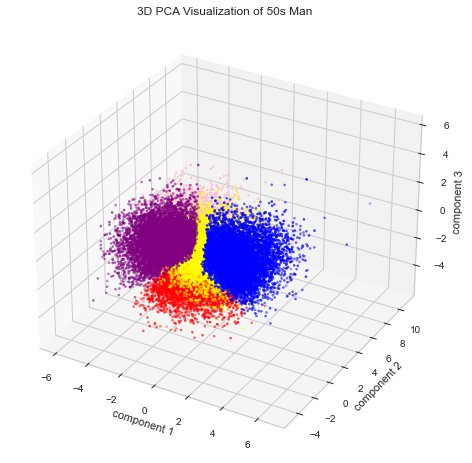

In [6]:
pca3 = PCA(n_components=3)
data_pca3 = pca3.fit_transform(scaled_data_man_df)
pca_df = pd.DataFrame(data_pca3, columns = ['component 0', 'component 1', 'component 2'])
pca_df['target'] = original_data_man['cluster']

# target 별 분리
pca_df_0 = pca_df[pca_df['target'] == 0]
pca_df_1 = pca_df[pca_df['target'] == 1]
pca_df_2 = pca_df[pca_df['target'] == 2]
pca_df_3 = pca_df[pca_df['target'] == 3]
pca_df_4 = pca_df[pca_df['target'] == 4]

# target 별 시각화
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df_0['component 0'], pca_df_0['component 1'], pca_df_0['component 2'], s = 5, color = 'pink', label = '0')
ax.scatter(pca_df_1['component 0'], pca_df_1['component 1'], pca_df_1['component 2'], s = 5, color = 'purple', label = '1')
ax.scatter(pca_df_2['component 0'], pca_df_2['component 1'], pca_df_2['component 2'], s = 5, color = 'yellow', label = '2')
ax.scatter(pca_df_3['component 0'], pca_df_3['component 1'], pca_df_3['component 2'], s = 5, color = 'red', label = '3')
ax.scatter(pca_df_4['component 0'], pca_df_4['component 1'], pca_df_4['component 2'], s = 5, color = 'blue', label = '4')

ax.set_title('3D PCA Visualization of 50s Man')
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set_zlabel('component 3')
plt.show()

* plotly를 활용한 3차원 데이터 시각화 (회전 기능사용)

In [7]:
import plotly.io as pio
pio.renderers.default='browser'
import plotly.express as px
fig = px.scatter_3d(pca_df, x='component 0', y='component 1', z='component 2',
              color='target')
fig.update_traces(marker_size = 1)
fig.show()

* 각 클러스터의 Feature 쌍별로 분포 확인

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\hyunj\Anaconda3\lib\site-packages\seaborn\_decorators.py:3

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 55137 (\N{HANGUL SYLLABLE HEUB}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 53468 (\N{HANGUL SYLLABLE TAE}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.p

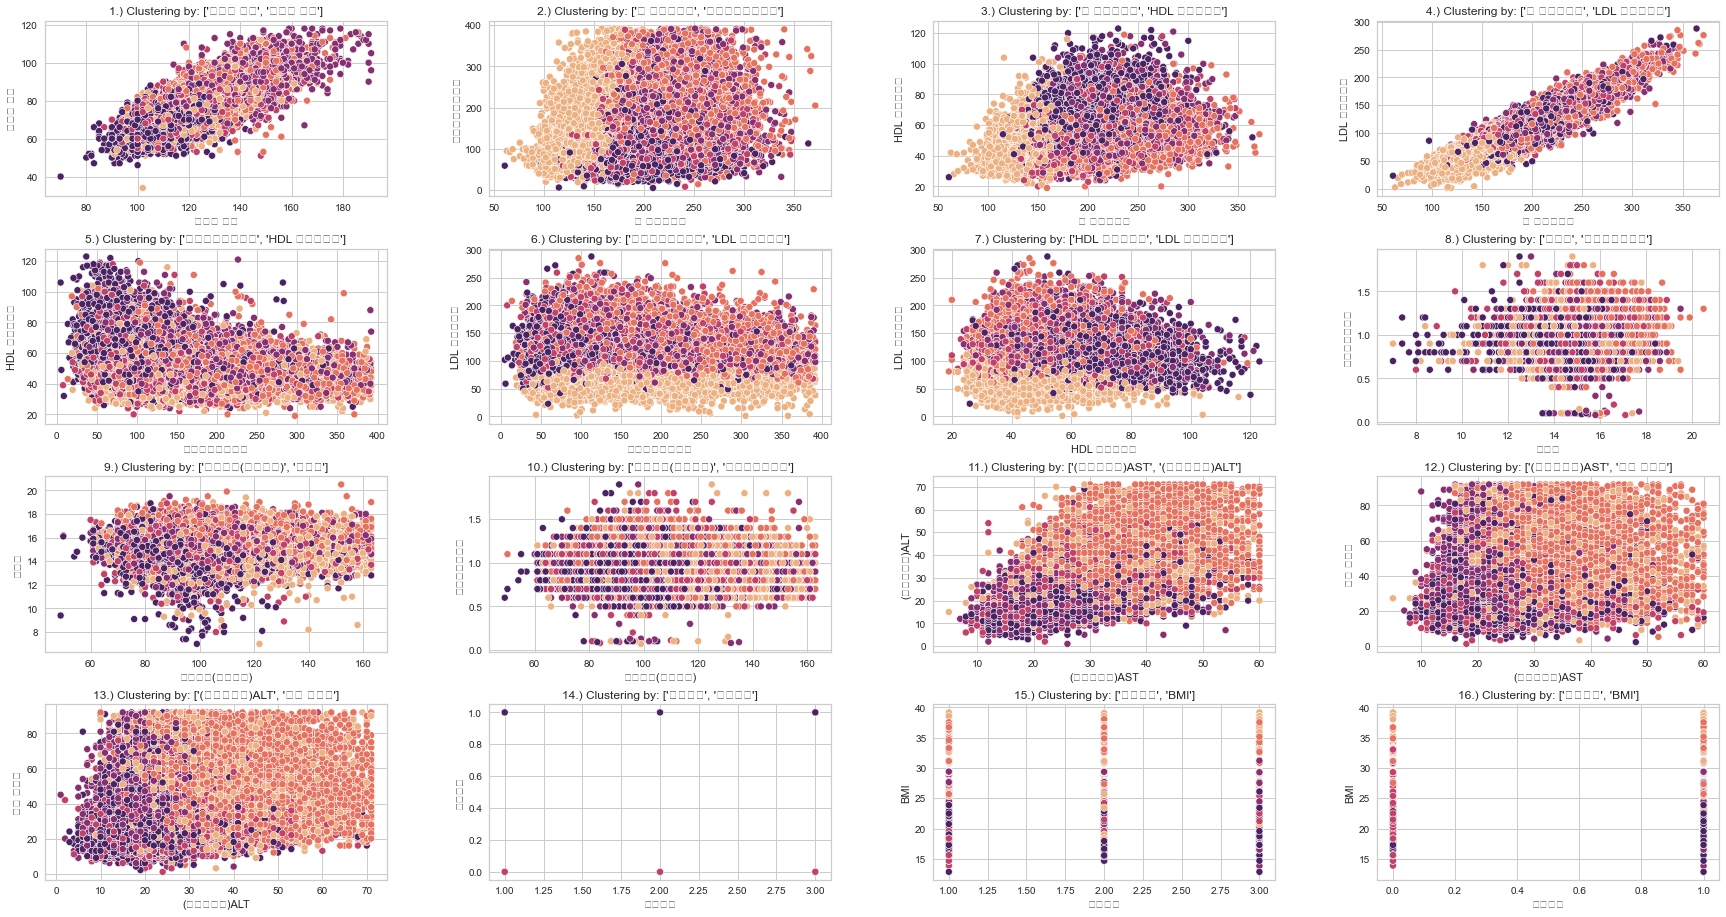

In [8]:
kmean_data = original_data_man2.copy()
i = 1
kmean_clusters = [["수축기 혈압", "이완기 혈압"], ["총 콜레스테롤", "트리글리세라이드"], ["총 콜레스테롤", "HDL 콜레스테롤"], ["총 콜레스테롤", "LDL 콜레스테롤"], 
            ["트리글리세라이드", "HDL 콜레스테롤"], ["트리글리세라이드", "LDL 콜레스테롤"], ["HDL 콜레스테롤", "LDL 콜레스테롤"], ["혈색소", "혈청크레아티닌"],
            ["식전혈당(공복혈당)", "혈색소"], ["식전혈당(공복혈당)", "혈청크레아티닌"], ["(혈청지오티)AST", "(혈청지오티)ALT"],
            ["(혈청지오티)AST", "감마 지티피"], ["(혈청지오티)ALT", "감마 지티피"], ["흡연상태", "음주여부"], ["흡연상태", "BMI"], ["음주여부", "BMI"]]

plt.figure(figsize=(30, 20))
for cluster in kmean_clusters:
    X_kmean = kmean_data[cluster]
    y_kmeans = original_data_man['cluster']
    
    plt.subplot(5, 4, i)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.title(f"{i}.) Clustering by: {cluster}")
    sns.scatterplot(X_kmean.loc[:, cluster[0]], X_kmean.loc[:, cluster[1]], c=y_kmeans, s=50, cmap="flare")
    #centers = kmeans.cluster_centers_
    #sns.scatterplot(centers[:, 0], centers[:, 1], s=200, color="k", alpha=0.5)
    i+=1

plt.show()

* Feature 별 클러스터의 분포 확인

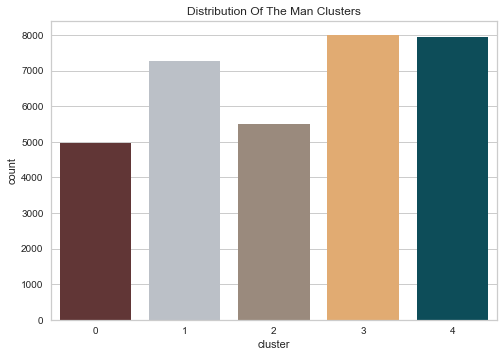

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 54792 (\N{HANGUL SYLLABLE HYEOL}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 54000 (\N{HANGUL SYLLABLE TI}) missing from current font.



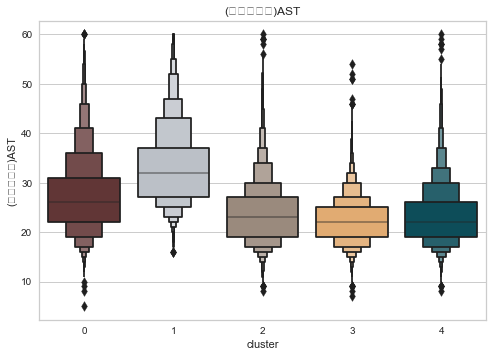

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 54792 (\N{HANGUL SYLLABLE HYEOL}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 54000 (\N{HANGUL SYLLABLE TI}) missing from current font.



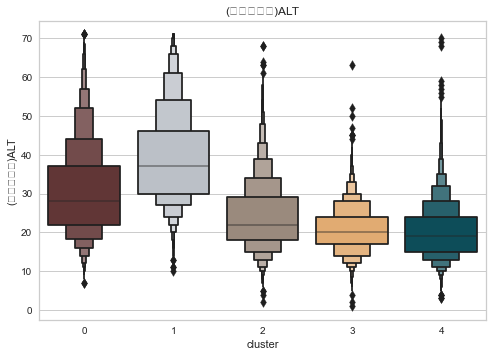

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 54000 (\N{HANGUL SYLLABLE TI}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from current font.



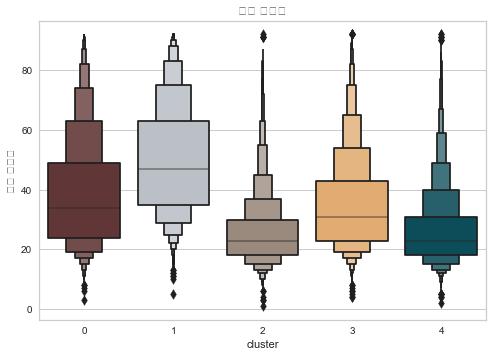

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 53084 (\N{HANGUL SYLLABLE KOL}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 47204 (\N{HANGUL SYLLABLE ROL}) missing from current font.



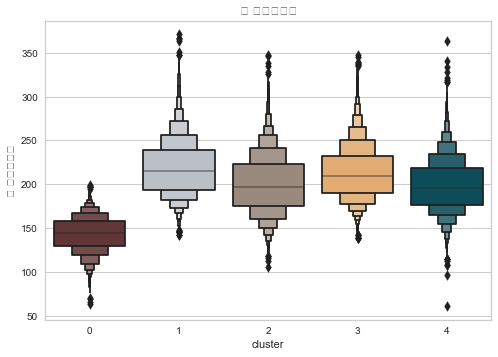

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 44544 (\N{HANGUL SYLLABLE GEUL}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151:

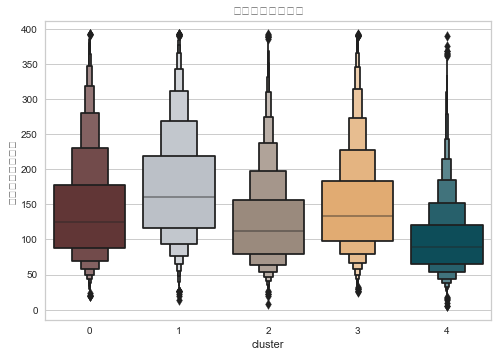

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 53084 (\N{HANGUL SYLLABLE KOL}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 47204 (\N{HANGUL SYLLABLE ROL}) missing from current font.



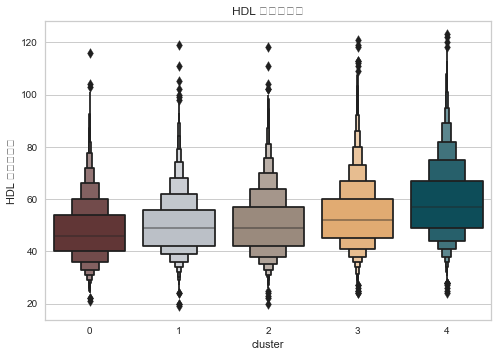

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 53084 (\N{HANGUL SYLLABLE KOL}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 47204 (\N{HANGUL SYLLABLE ROL}) missing from current font.



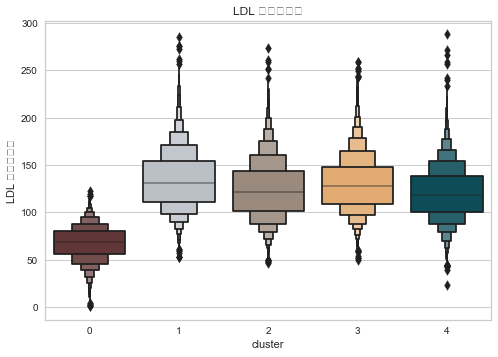

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 52629 (\N{HANGUL SYLLABLE CUG}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 54792 (\N{HANGUL SYLLABLE HYEOL}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 50517 (\N{HANGUL SYLLABLE AB}) missing from current font.



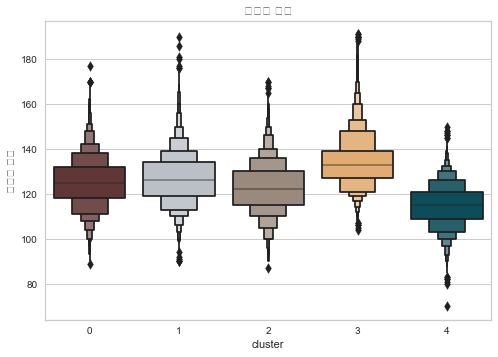

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 50756 (\N{HANGUL SYLLABLE WAN}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 54792 (\N{HANGUL SYLLABLE HYEOL}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 50517 (\N{HANGUL SYLLABLE AB}) missing from current font.



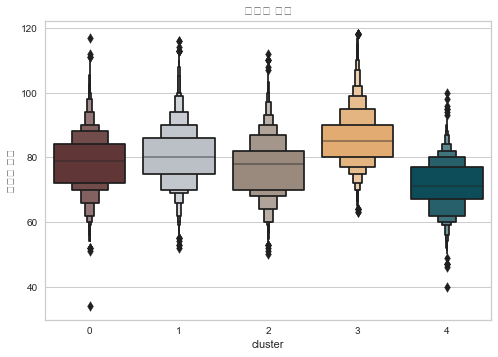

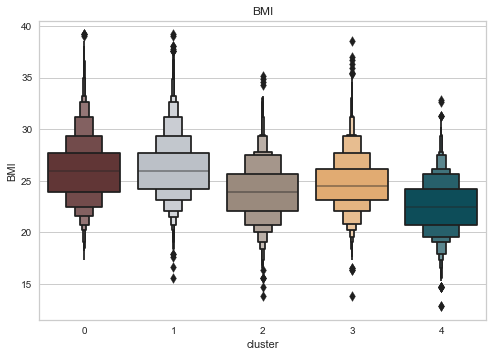

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 54792 (\N{HANGUL SYLLABLE HYEOL}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.



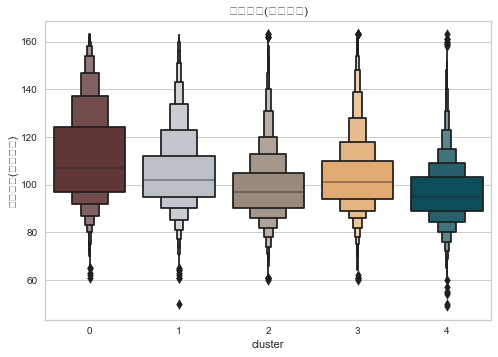

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 54792 (\N{HANGUL SYLLABLE HYEOL}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 49353 (\N{HANGUL SYLLABLE SAEG}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.



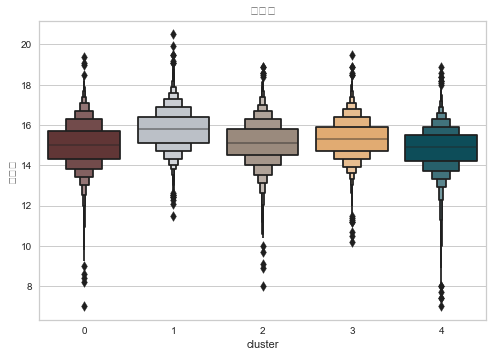

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 54792 (\N{HANGUL SYLLABLE HYEOL}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 54000 (\N{HANGUL SYLLABLE TI}) missing from current font.

C:\Users\hyunj\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:

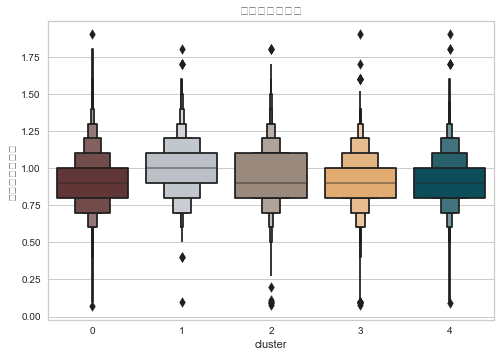

In [9]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60", "#005666"]
pl = sns.countplot(x=original_data_man["cluster"], palette= pal)
pl.set_title("Distribution Of The Man Clusters")
plt.show()

temp = list(original_data_man.columns)

# 간장질환
간장질환 = ["(혈청지오티)AST", "(혈청지오티)ALT", "감마 지티피"]
for i in 간장질환 : 
    plt.figure()
    pl=sns.boxenplot(x=original_data_man["cluster"], y=original_data_man2[i], palette=pal)
    plt.title(i)
    plt.show()
    
# 이상지지혈증
이상지질혈증  = ["총 콜레스테롤", "트리글리세라이드", "HDL 콜레스테롤", "LDL 콜레스테롤"]
for i in 이상지질혈증 : 
    plt.figure()
    pl=sns.boxenplot(x=original_data_man["cluster"], y=original_data_man2[i], palette=pal)
    plt.title(i)
    plt.show()

# 심뇌혈관질환
심뇌혈관질환 = ["수축기 혈압", "이완기 혈압"]
for i in 심뇌혈관질환 : 
    plt.figure()
    pl=sns.boxenplot(x=original_data_man["cluster"], y=original_data_man2[i], palette=pal)
    plt.title(i)
    plt.show()

# 그 외
나머지 = ["BMI", "식전혈당(공복혈당)", "혈색소", "혈청크레아티닌"]
for i in 나머지 : 
    plt.figure()
    pl=sns.boxenplot(x=original_data_man["cluster"], y=original_data_man2[i], palette=pal)
    plt.title(i)
    plt.show()